# Part 1: Build CpG Detector

Here we have a simple problem, given a DNA sequence (of N, A, C, G, T), count the number of CpGs in the sequence (consecutive CGs).

We have defined a few helper functions / parameters for performing this task.

We need you to build a LSTM model and train it to complish this task in PyTorch.

A good solution will be a model that can be trained, with high confidence in correctness.
Project Name: CpG Detector
Description:
The project requires you to build a neural network to count the number of CpGs (consecutive
CGs) in given DNA (of N, A, C, G, T) sequences.
Example, given “NCACANNTNCGGAGGCGNA”, the corrected output should be 2.
Requirement:
1. You need to build a LSTM-based solution using PyTorch. (Hint: why we require to
solve with LSTM)
2. You can test different settings (model architecture / loss functions / hyper-parameters)
along with the parameters already provided in the material (jupyter notebook we
provided) to optimize your solution. (we would like to see how you think through this
process)
3. You can use any tools like google search / stackoverflow / even chatGPT, but you
have to show us how you use them to help you finish the task.
Task:
We will provide a jupyter notebook with some code implemented (not complete and may have
bugs), you need to complete the task based on the requirement, make the model running,
perform a simple evaluation, and demo your results (build a simple web app).
1. You need to prepare a web app (using streamlit or flask) to allow us to test your
model. Basically, you will expect we give you an input and your app (model+UI) can
give a proper model output. For example, you can have an input window where we
ask you to input a string like “NCACANNTNCGGAGGCGNA”, then you can have an
output where you show us the outputs from the model (your model outputs could be
1.96 or 2.04 and we would like you to show us the raw outputs).
2. You need to send back the code (only the jupyter notebook) with the outputs that you
think are valuable for the team.
3. Be prepared on how you approach it. We are not interested in how good the model
you build but how you think of the problem and how you solve it with a proper method.

In [3]:
from typing import Sequence
from functools import partial
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [4]:
# DO NOT CHANGE HERE
def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(13)

# Use this for getting x label
def rand_sequence(n_seqs: int, seq_len: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        yield [random.randint(0, 4) for _ in range(seq_len)]

# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs

# Alphabet helpers
alphabet = 'NACGT'
dna2int = { a: i for a, i in zip(alphabet, range(5))}
int2dna = { i: a for a, i in zip(alphabet, range(5))}

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [5]:
# we prepared two datasets for training and evaluation
# training data scale we set to 2048
# we test on 512

def prepare_data(num_samples=100):
    # prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    # step 1
    X_dna_seqs_train = list(rand_sequence(num_samples))
    """
    hint:
        1. You can check X_dna_seqs_train by print, the data is ids which is your training X
        2. You first convert ids back to DNA sequence
        3. Then you run count_cpgs which will yield CGs counts - this will be the labels (Y)
    """
    #step2
    temp = [''.join(intseq_to_dnaseq(seq)) for seq in X_dna_seqs_train] #??? use intseq_to_dnaseq here to convert ids back to DNA seqs
    #step3
    y_dna_seqs = [count_cpgs(seq) for seq in temp] #??? use count_cpgs here to generate labels with temp generated in step2

    return X_dna_seqs_train, y_dna_seqs

train_x, train_y = prepare_data(2048)
test_x, test_y = prepare_data(512)

In [6]:
# some config
LSTM_HIDDEN = 50 #???
LSTM_LAYER = 2 #???
batch_size = 64 #???
learning_rate = 0.001 #???
epoch_num = 20 #???

In [7]:

def one_hot_encode(sequence, num_classes=5):
    # Convert the sequence to a tensor
    sequence_tensor = torch.tensor(sequence, dtype=torch.long)
    # One-hot encode the sequence
    one_hot = F.one_hot(sequence_tensor, num_classes=num_classes)
    return one_hot.float()

# Apply one-hot encoding to your datasets
train_x_one_hot = [one_hot_encode(seq) for seq in train_x]
test_x_one_hot = [one_hot_encode(seq) for seq in test_x]

# Convert list of one-hot encoded tensors to a single tensor
train_x_tensor = torch.stack(train_x_one_hot)
test_x_tensor = torch.stack(test_x_one_hot)


# Assuming train_y and test_y are lists of labels (counts of CpG sites)
# Convert the list of labels to PyTorch tensors
train_y_tensor = torch.tensor(train_y, dtype=torch.float32).view(-1, 1)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32).view(-1, 1)

# Create TensorDataset objects with one-hot encoded data
train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

# Create DataLoader objects
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
from logging import lastResort
# Model
class CpGPredictor(nn.Module):
    ''' Simple model that uses a LSTM to count the number of CpGs in a sequence '''
    def __init__(self,input_size=5, hidden_size=50, num_layers=2, output_size=1):
        super(CpGPredictor, self).__init__()
        # TODO complete model, you are free to add whatever layers you need here
        # We do need a lstm and a classifier layer here but you are free to implement them in your way
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.classifier = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # TODO complete forward function
        lstm_out, _ = self.lstm(x)
        # Extract the last time step's output
        last_output = lstm_out[:, -1, :]
        logits = self.classifier(last_output)
        return logits

In [9]:
# init model / loss function / optimizer etc.
model = CpGPredictor()
loss_fn = nn.MSELoss() #???
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #???

In [10]:
# training (you can modify the code below)
t_loss = 0.0
model.train()
model.zero_grad()

for epoch in range(epoch_num):
    for batch in train_data_loader:
        # Unpack the batch
        inputs, labels = batch

        # Forward pass: Compute predicted y by passing x to the model
        outputs = model(inputs)

        # Compute the loss
        loss = loss_fn(outputs, labels)

        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        t_loss += loss.item()

    # Print the average loss for this epoch
    print(f'Epoch {epoch+1}/{epoch_num}, Loss: {t_loss/len(train_data_loader):.4f}')
    print(t_loss)
    t_loss = 0.0 # Reset the loss for the next epoch

Epoch 1/20, Loss: 21.6772
693.6719260215759
Epoch 2/20, Loss: 5.0923
162.9524540901184
Epoch 3/20, Loss: 4.2151
134.88455367088318
Epoch 4/20, Loss: 4.1957
134.26206064224243
Epoch 5/20, Loss: 4.1953
134.2491946220398
Epoch 6/20, Loss: 4.1967
134.29592561721802
Epoch 7/20, Loss: 4.2061
134.59453225135803
Epoch 8/20, Loss: 4.1931
134.17864537239075
Epoch 9/20, Loss: 4.1991
134.372323513031
Epoch 10/20, Loss: 4.1999
134.3957073688507
Epoch 11/20, Loss: 4.1960
134.27229642868042
Epoch 12/20, Loss: 4.1969
134.29972124099731
Epoch 13/20, Loss: 4.1954
134.25291681289673
Epoch 14/20, Loss: 4.1963
134.28156185150146
Epoch 15/20, Loss: 4.1988
134.36114692687988
Epoch 16/20, Loss: 4.1960
134.27130436897278
Epoch 17/20, Loss: 4.1989
134.36527180671692
Epoch 18/20, Loss: 4.1954
134.25135922431946
Epoch 19/20, Loss: 4.1940
134.207111120224
Epoch 20/20, Loss: 4.1953
134.2491180896759


In [11]:
# Set the model to evaluation mode
model.eval()

# Lists to store ground truth and predictions
res_gs = []
res_pred = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in test_data_loader:
        # Unpack the batch
        inputs, labels = batch

        # Forward pass: Compute predicted y by passing x to the model
        outputs = model(inputs)

        # Store the ground truth and predictions
        res_gs.extend(labels.numpy().flatten())  # Flatten to ensure it's a 1D list
        res_pred.extend(outputs.numpy().flatten())  # Flatten to ensure it's a 1D list

# Convert results to numpy arrays for further analysis if needed
res_gs = np.array(res_gs)
res_pred = np.array(res_pred)

# Optionally, calculate metrics such as Mean Squared Error
mse = np.mean((res_gs - res_pred) ** 2)
print(f'Mean Squared Error: {mse:.4f}')

Mean Squared Error: 4.1576


Mean Absolute Error: 1.5880


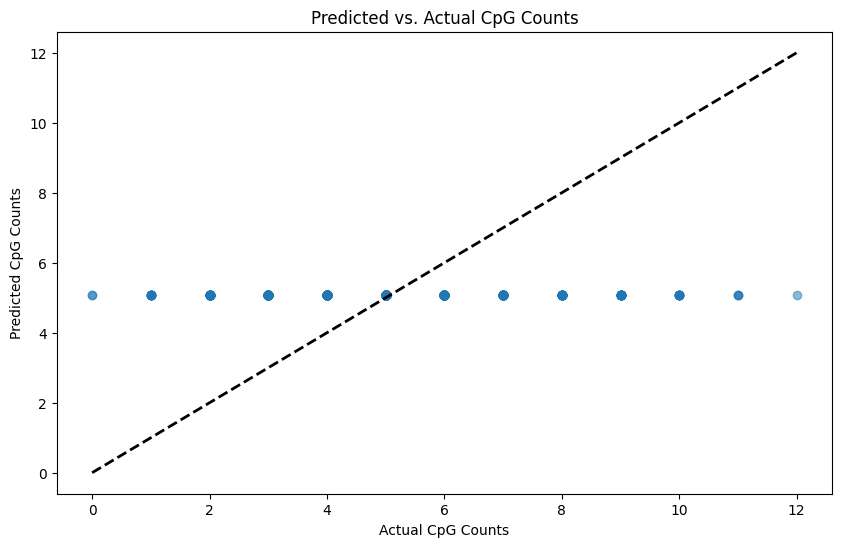

Maximum Error: 6.9354
Minimum Error: -5.0648


In [12]:
# TODO complete evaluation of the model
import matplotlib.pyplot as plt

# Calculate additional metrics
mae = np.mean(np.abs(res_gs - res_pred))
print(f'Mean Absolute Error: {mae:.4f}')

# Plot predicted vs. actual CpG counts
plt.figure(figsize=(10, 6))
plt.scatter(res_gs, res_pred, alpha=0.5)
plt.plot([res_gs.min(), res_gs.max()], [res_gs.min(), res_gs.max()], 'k--', lw=2)
plt.xlabel('Actual CpG Counts')
plt.ylabel('Predicted CpG Counts')
plt.title('Predicted vs. Actual CpG Counts')
plt.show()

# Analyze errors
errors = res_gs - res_pred
print(f'Maximum Error: {errors.max():.4f}')
print(f'Minimum Error: {errors.min():.4f}')

In [13]:

torch.save(model.state_dict(), 'cpg_detector_model.pth')
